# K-Means for Grouping Predictors of Alcohol Abuse #

** Submitted as part of Machine Learning for Data Analysis by Wesleyan University **
** Author: Oliver Morris **
** Date: 31 March 2016 **

The below analysis will show the code and describe the context of a k-means model constructed in python which identifies clusters within the National Epidemiologic Survey on Alcohol and Related Conditions (NESARC) data set. This is a standard data set for the Wesleyan Univeristy course in Machine Learning & Data Analysis at Coursera. 

The objective is to discover whether the clusters are signficant with respect to the age at onset of alcohol abuse. Although the clusters appear to be distinct, the validation results show no significant relationship between the clusters and the reported age of alcohol abuse.

FYI. This blog entry was published using Jupyter notebooks, which is designed for sharing reproducible data science in python. The code was prepared in Visual Studio 2015 Community Edition on Windows 10 with the Anaconda Python Environment and an IPython interactive window installed.

## Dependencies ##

The packages used are the same as for the example code, however, pandasql which is sql-lite for python, has also been introduced. This is used in the cleaning of the NESARC data into a format usable by the decision tree code.

The scikit-learn (aka sklearn) package is used for the random forest tool

In [2]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import os
import warnings
warnings.filterwarnings('ignore')

## Data Preparation ##

The NESARC data set is large, over 40,000 rows and 3,000 columns, 258Mb. Reading the data into a pandas object is straightforward, but takes some time.

14 columns of data were hand selected as candidates for clustering. 13 will be sued for the initial clustering model and 1 will be used for validating that mdoel. 

The data is filtered to remove blanks and 'unknowns'. The NESARC data has many blanks and special rules are developed to deal with these.

Next, the selected data is 'normalised' so that each parameter has mean=0, sd=1, i.e. all parameters share a common scale. This is required by the K-Means method, which would otherwise heavily penalise small scale parameters, which may be important.

In [3]:
os.chdir("C:/Users/Oliver/Documents/0_OM/Training/WesleyanPython/0_Data")

#Load the dataset
NESARC_data = pd.read_csv("nesarc_pds.csv")
NESARC_data_exNA = NESARC_data.dropna()

In [36]:
#Select target variable and target variable as separate data sets
#Age at onset of alcohol abuse. 0-99, BL = no alcohol abuse, so assume 100
subset=pd.DataFrame()
subset['AgeAtOnsetAlcAbuse'] = NESARC_data_exNA['S2BQ3A'].replace(r'\s+', 100, regex=True).astype(int)

#Select predictor variables and target variable as separate data sets
#Note, the underlying data uses blanks frequently, which need to be cleaned up.

#Origin or descent: 1-98. 99=unknown
subset['Origin']  = NESARC_data_exNA['S1Q1E'].replace(r'\s+', 99, regex=True).astype(int)

#Raised by adoptive parents before age 18: 1=Y, 2=N, 9=unknown, BL=2
subset['Adopted'] = NESARC_data_exNA['S1Q2C1'].replace(r'\s+', 2, regex=True).astype(int)

#Biological father ever live in household before respondent was 18: 1=Y, 2=N, 9=unknown, BL=2
subset['BiologicalFather']  = NESARC_data_exNA['S1Q2B'].replace(r'\s+',  2, regex=True).astype(int)

#Raised in an institution before age 18: 1=Y, 2=N, 9=unknown, BL=2 
subset['Institutionalised'] = NESARC_data_exNA['S1Q2C4'].replace(r'\s+', 2, regex=True).astype(int)

#Parental divorce before 18, 1=Yes, 2=No, 9=Unknown. Default for blank is No (2)
subset['ParentsDivorced']  = NESARC_data_exNA['S1Q2D'].replace(r'\s+',  2, regex=True).astype(int)

#Parent death before 18, 1=Yes, 2=No, 9=Unknown. Default for blank is No (2) 
subset['ParentDeath']  = NESARC_data_exNA['S1Q2K'].replace(r'\s+',  2, regex=True).astype(int)

#Age at death of biological or adoptive parent: 1-99, 99=Unknown, BL=99. Default for blank is unknown (99) 
subset['AgeAtParentDeath']  = NESARC_data_exNA['S1Q2L'].replace(r'\s+', 99, regex=True).astype(int)

#Age at first marriage: 1-99, 99=Unknown, BL=99. Default for blank is unknown (99) 
subset['AgeAtMarriage']  = NESARC_data_exNA['S1Q4A'].replace(r'\s+', 99, regex=True).astype(int)

#Children ever had, including adoptive, step and foster children: 0-14, 99=unknown
subset['QtyChildren']  = NESARC_data_exNA['S1Q5A'].astype(int)

#Highest grade or year of school completed: 1 - 14                     
subset['EducationalAchievement']  = NESARC_data_exNA['S1Q6A'].astype(int)

#Current marital status: 1 = married, 2 =cohabiting, 3=widowed, 4=divorced, 5=separated, 6=single                   
subset['MaritalStatus']= NESARC_data_exNA['MARITAL'].astype(int)

#Age                
subset['Age']    = NESARC_data_exNA['AGE'].astype(int)

#Sex: 1=M, 2=F
subset['Sex']    = NESARC_data_exNA['SEX'].astype(int)

#Remove the 'unknown' values (i.e. AgeAtOnsetAlcAbuse = 99 or 100)
cluster = subset[
          (subset.Origin != 99) & (subset.Adopted != 9) & (subset.BiologicalFather !=  9) & (subset.Institutionalised != 9) & 
          (subset.ParentsDivorced != 99) & (subset.ParentDeath != 9 ) & (subset.AgeAtOnsetAlcAbuse < 99)]
 
# Force the row 'index' into its own column - this is used later for merging with other data
cluster.reset_index(inplace=True)
cluster['index'] = cluster.index

In [37]:
# normalise parameters to have mean=0 and sd=1

clustervar=pd.DataFrame()
from sklearn import preprocessing

clustervar['Origin']=preprocessing.scale(cluster['Origin'].astype('float64'))
clustervar['Adopted']=preprocessing.scale(cluster['Adopted'].astype('float64'))
clustervar['BiologicalFather']=preprocessing.scale(cluster['BiologicalFather'].astype('float64'))
clustervar['Institutionalised']=preprocessing.scale(cluster['Institutionalised'].astype('float64'))
clustervar['ParentsDivorced']=preprocessing.scale(cluster['ParentsDivorced'].astype('float64'))
clustervar['ParentDeath']=preprocessing.scale(cluster['ParentDeath'].astype('float64'))
clustervar['AgeAtParentDeath']=preprocessing.scale(cluster['AgeAtParentDeath'].astype('float64'))
clustervar['AgeAtMarriage']=preprocessing.scale(cluster['AgeAtMarriage'].astype('float64'))
clustervar['QtyChildren']=preprocessing.scale(cluster['QtyChildren'].astype('float64'))
clustervar['EducationalAchievement']=preprocessing.scale(cluster['EducationalAchievement'].astype('float64'))
clustervar['MaritalStatus']=preprocessing.scale(cluster['MaritalStatus'].astype('float64'))
clustervar['Age']=preprocessing.scale(cluster['Age'].astype('float64'))
clustervar['Sex']=preprocessing.scale(cluster['Sex'].astype('float64'))


## Model Training ##

The data is split into training and test sets, with 30% retained for test. Then the K-Means model can be assembled, using KMeans from the sklearn.cluster package. 

In fact, 9 cluster models are generated, which allows us to view how the mean distance from the centroids reduces as the number of centroids increases. The relationship is not linear, there is an 'elbow', a point of reducing returns for increasing centroids.

This elbow is plotted below, showing up at around k=3

In [38]:
# split data into train and test sets
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

#We're working in 9 dimensional space, so need to simplify the results
#Calculate the average distance from observations to cluster centers across all predictors (i.e. columns) 

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

<IPython.core.display.Javascript object>


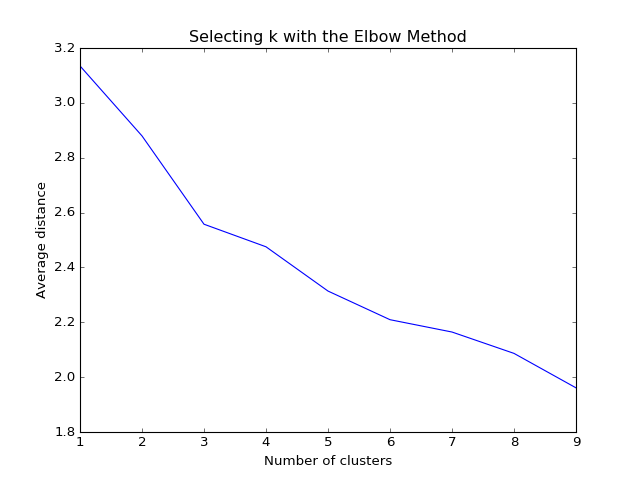

In [39]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

## Building a Simpler, k=3 Model ##

From visual inspection the elbow is around 3-4. Having identified 3 clusters as being sufficient, we can build a k=3 model. 
The clusters can be visualised on a 2D chart by using PCA to reduce the 13 dimensions to 2 (x,y). 

<IPython.core.display.Javascript object>


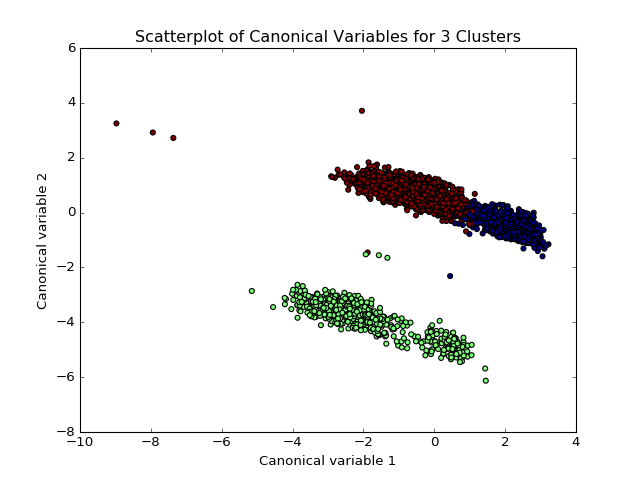

In [42]:
# build a k=3 cluster model

model_simple=KMeans(n_clusters=3)
model_simple.fit(clus_train)
clusassign=model_simple.predict(clus_train)

# plot clusters by using PCA to squeeze the 13 parameters into 2 'canonical variables' for the plot axes (x, y)

from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)

%matplotlib notebook
import matplotlib.pyplot as plt

plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model_simple.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.show()

## Interpreting the k=3 Model ##

From the above chart we can see that the green cluster (no.1) is entirely distinct. The other two border each other but are fairly distinct. This is a good sign that the algorithm has found differences in the populations.

We can evaluate the clusters more scientifically by calculating the mean value for each of the 13 parameters within each cluster to see how the clusters differ. The results are below:

**Cluster 0. Population = 4,573**

- Single, parents still alive, in their thirties, more likely to be immigrant community.

**Cluster 1. Population = 1,693**

- Married or living with someone, coupled later in life, parent died whilst a child, mid forties, less likely to be immigrant community.

**Cluster 2. Population = 651**

- Married or living with someone, coupled earlier in life, parents alive, mid forties, most likely to be immigrant community.

In [44]:
# Create a list of the observations identifying which cluster each belongs to.

merged_train = pd.DataFrame()
merged_train['index']=clus_train.index
merged_train['cluster']=model_simple.labels_

# Merge the training data (which has not been normalised) with the assigned cluster 

merged_train = pd.merge(merged_train, cluster, on='index')

# Remove the validation column of data, this is handled later...

merged_train = merged_train.drop(['AgeAtOnsetAlcAbuse'], axis=1)

# For each cluster calculate the mean of each parameter

clustergrp = merged_train.groupby('cluster').mean()
print ("\n====================================\nObservations per cluster\n====================================\n")
print(merged_train.cluster.value_counts())
print ("\n====================================\nClustering variable means by cluster\n====================================\n")
print(clustergrp)


Observations per cluster

2    4573
0    1693
1     651
Name: cluster, dtype: int64

Clustering variable means by cluster

               index     Origin   Adopted  BiologicalFather  \
cluster                                                       
0        5355.759008  24.580626  1.982871          1.144123   
1        4943.350230  21.228879  1.989247          1.181260   
2        4815.218675  25.518259  1.990816          1.114148   

         Institutionalised  ParentsDivorced  ParentDeath  AgeAtParentDeath  \
cluster                                                                      
0                 1.999409         1.730065     1.999409         99.000000   
1                 2.000000         1.663594     1.000000         10.311828   
2                 1.999563         1.822655     1.999781         99.000000   

         AgeAtMarriage  QtyChildren  EducationalAchievement  MaritalStatus  \
cluster                                                                      
0            

## Validation of the k=3 Model ##

The model clusters can be validated by examining how well those clusters segment another, previously unanalysed, parameter for each observation.

The chosen parameter is the age at onset of alcohol abuse, column 'S2BQ3A' in the NESARC data, which is labelled as 'AgeAtOnsetAlcAbuse' in this analysis. In previous projects from this course, this column was the chosen target, aka outcome.

This is done in two ways 

1. Analysing the means for alcohol abuse within each cluster, are they significantly different? The means and SD's are calculated then a Tukey test for significance is completed. 

2. Using Ordinary Least Squares regression to model alcabuse based on the cluster assigned by the above k-means analysis. High R.squared would indicate some realtionship.


In [51]:
# Get the data...

cluster_alcabuse = subset[['AgeAtOnsetAlcAbuse']]

# Split this data into train and test. Note the use of the same random_state so that the same observations 
# are in this training set as were used in the training set for the original 13 parameters.

cluster_alcabuse_train, cluster_alcabuse_test = train_test_split(cluster_alcabuse, test_size=.3, random_state=123)

# Merge the training set for this new parameter with the 13 original parameters and their assigned cluster
# To aide merging with existing data, first force the 'index' into its own column

cluster_alcabuse_train.reset_index(level=0, inplace=True)

cluster_alcabuse_train = pd.DataFrame(cluster_alcabuse_train)
merged_train_all=pd.merge(cluster_alcabuse_train, merged_train, on='index')
sub1 = merged_train_all[['AgeAtOnsetAlcAbuse', 'cluster']].dropna()

# Now calculate the means and SD's of the populations of each cluster.
# Then the populations can be tested to understand whether their means are significantly different.

print ('\n====================================\nMeans for age at onset of alcohol abuse by cluster\n====================================\n')
m1= sub1.groupby('cluster').mean()
print (m1)

print ('\n====================================\nStandard deviations for age at onset of alcohol abuse by cluster\n====================================\n')
m2= sub1.groupby('cluster').std()
print (m2)

# Calculate statisitical significance of difference within the three clusters.
# NB calculating differences between three sets is aided by use of a Tukey test.

import statsmodels.stats.multicomp as multi 

mc1 = multi.MultiComparison(sub1['AgeAtOnsetAlcAbuse'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print ('\n====================================\nTukey Test of AgeAtOnsetAlcAbuse vs cluster\n====================================\n')
print(res1.summary())

# What R.squared do we get when we do regression between GP and the label of the assigned cluster?

import statsmodels.formula.api as smf

alcabusemod = smf.ols(formula='AgeAtOnsetAlcAbuse ~ C(cluster)', data=sub1).fit()
print ('\n====================================\nLinear Regression of AgeAtOnsetAlcAbuse vs cluster\n====================================\n')
print (alcabusemod.summary())


Means for age at onset of alcohol abuse by cluster

         AgeAtOnsetAlcAbuse
cluster                    
0                 81.998351
1                 80.058212
2                 81.186823

Standard deviations for age at onset of alcohol abuse by cluster

         AgeAtOnsetAlcAbuse
cluster                    
0                 32.819689
1                 33.918480
2                 33.310009

Tukey Test of AgeAtOnsetAlcAbuse vs cluster

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -1.9401  -6.1406 2.2603 False 
  0      2    -0.8115  -3.4265 1.8034 False 
  1      2     1.1286  -2.6743 4.9315 False 
--------------------------------------------

Linear Regression of AgeAtOnsetAlcAbuse vs cluster

                            OLS Regression Results                            
Dep. Variable:     AgeAtOnsetAlcAbuse   R-squared:                       0.000
Model:                

## Results ##

The result is that there appears to be small difference in age at onset of alcohol abuse for cluster 1, who suffered parental loss whilst a child. However, the Tukey test finds that there is no significance to this difference. Furthermore, the linear regression shows no relationship between age at onset of alcohol abuse and the clusters identified above.